In [ ]:
########################################################################################################
##   Self Organizing Map for Python
##   Author: Shooby Hemmati
##   Date last edited: 09/1/2016
##   Adapted mostly from SOMPY (https://github.com/sevamoo/SOMPY), 
##   slightly modified, extensively simplified.
##
##
##   Self-Organizing Map features:
##   
##        Topology:               Rectangular
##        Initializitaion:        Random
##        Training:               Batch
##        Distance type:          Weighted Euclidean (allowing to miss bad data)
##        Neighborhood function:  Gaussian
##        
##   
##   Input:
##
##        2D Data matrix          "dlen" vectors of "features" dimension
##
##   Optional input parameters (defaults):
##
##        number_neurons:         5x(n)^0.5
##        ratio_sidetolength:     ratio of two greatest eigenvalues of the covarience matrix
##        neighborhood_radius:    from ? to 1
##        training_epochs:        m/n passes throught the data
##
##
##   Usage:
##    
##       this_som=SOM(training_data,mapsize=[x,y])
##       som_values=this_som.train()
##
########################################################################################################

In [1]:
#a=pyfits.getdata('wfirst_sample_candels.fits')
import numpy as np
import pyfits
import matplotlib.pyplot as plt
%matplotlib inline

a=pyfits.getdata('/Users/Shooby/Dropbox/WPS/WFIRST_CANDELS_cfhtlsfilters/CANDELS_CFHT_interp.fits')
ug=np.array((a['u']-a['g']))
gr=np.array((a['g']-a['r']))
ri=np.array((a['r']-a['i']))
iz=np.array((a['i']-a['z']))
zy=np.array((a['z']-a['y']))
yj=np.array((a['y']-a['j']))
jh=np.array((a['j']-a['h']))
hk=np.array((a['h']-a['k']))

sel=(ug>-5) & (ug<5) &(gr>-5) & (gr<5) &(ri>-5) & (ri<5) &(iz>-5) & (iz<5) &(zy>-5) & (zy<5) & (yj>-5) & (yj<5) & (jh>-5) & (jh<5) &(hk>-5) & (hk<5)

dat=np.array([ug[sel],gr[sel],ri[sel],iz[sel],zy[sel],yj[sel],jh[sel],hk[sel]])
data=dat.T
print np.shape(data)

(105337, 8)


/Users/shooby/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/Users/shooby/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less


In [2]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import RandomizedPCA   

class SOM(object):
    
    def __init__(self,data,mapsize=None,initialize='Random'):
        self.data=data
        self.mapsize=mapsize
        self.initialize=initialize
        ## size of the map
        self.dlen,self.features=np.shape(self.data)
        if self.mapsize is None:
            self.num_cells=int(5.0*self.dlen**0.6)
            temp=np.sort(np.linalg.eigvals(np.cov(data[0:100])))
            eigen_ratio=int(round(np.real(temp[-1])/np.real(temp[-2])))
            self.xsize=int((self.num_cells/eigen_ratio)**0.5)
            self.ysize=int(self.num_cells/self.xsize)
            self.num_cells=self.xsize*self.ysize
        else:
            self.xsize=self.mapsize[0]
            self.ysize=self.mapsize[1]
            self.num_cells=self.xsize*self.ysize
        ## random initialization of map
        if self.initialize is 'Random':
            self.codebook=np.random.uniform(low=0.0,high=2.0,size=[self.xsize,self.ysize,self.features]) 
        
        print "Self Organizing Map of size ("+str(self.xsize)+','+str(self.ysize)+") is initialized."
        
    def train(self,t=None):
        
        if t is None:
            t=1
        print "Rough training..."
        self.batchtrain(30*t,6.0,6.0) #rough
        print "Finetune training ..."
        self.batchtrain(50*t,12.0,25.0) #finetune
        print "Thats all folks!"
        
        return self.codebook

    
        
    def batchtrain(self,a,b,c):
        '''This will find the neighborhood of each cell and
        update the weights around BMUs. Inputs: a,b,c parameters 
        for length of training and radius of defining
        neighbothood depending on rough or finetune training.'''
        
        
        trainlen=max(int(a*float(self.num_cells)/float(self.dlen)),1)
        init_r=int(max(1.0,np.ceil(max(self.xsize,self.ysize)/b)))
        fin_r=int(max(1.0,init_r/c))
        radius = np.linspace(init_r, fin_r, trainlen)

        print "trainlen: "+str(trainlen)+'\t'+'initial radius: '+str(init_r)+'\t'+'final radius: '+str(fin_r)
        
        for i in range(trainlen):
            neighborhood = np.exp(-1.0*self.dist_matrix()/(2.0*radius[i]**2)).reshape(self.num_cells, self.num_cells)
            bmu = self.find_bmu()
            self.codebook= self.update_codebook(bmu,neighborhood)
        
        return self.codebook
    

    
    def update_codebook(self,bmu,neighborhood):
        nom=np.zeros((self.num_cells,self.features))
        denom=np.zeros((self.num_cells))

        for k in range(self.dlen):
            denom+=neighborhood[:,bmu[k,2]]
            nom+=neighborhood[:,bmu[k,2]].reshape(self.num_cells,1).dot(self.data[k,:].reshape(1,self.features))
        
        for f in range(self.features):
            nom[:,f]=np.divide(nom[:,f],denom[:])

        return nom.reshape(self.xsize,self.ysize,self.features)
    
    
    def dist_matrix(self):
        '''distance matrix for all cells of map to other cells, which will be 
        used in training'''
        distance_matrix = np.zeros((self.num_cells, self.num_cells))
        for i in range(self.num_cells):
            distance_matrix[i]=self.dist_to_node(i).reshape(1,self.num_cells)
        return distance_matrix
        
        
    def dist_to_node(self,node_ind):
        '''distance of all cells in the map to an individual node, which will be used to measure
        the distanc matrix.'''
        node_col = int(node_ind % self.ysize)
        node_row = int(node_ind / self.ysize)
        r = np.arange(0, self.xsize, 1)[:, np.newaxis]
        c = np.arange(0, self.ysize, 1)
        dist2 = (r-node_row)**2 + (c-node_col)**2
        dist = dist2.ravel()
        return dist
    
    
    def find_bmu(self):
        '''This finds the Best Matching Unit by comparing the input data
        to the SOM weights. Returns index i and j of the bmu'''
        
        ## for now this is euclidean should change to account for weights
        dlen = np.shape(self.data)[0]
        y2=np.einsum('ijk,ijk->ij',self.codebook,self.codebook)
        xy=-2.0*np.dot(self.codebook,self.data.T)
        xy=np.einsum('ijk,ij->ijk',xy,y2)
        bmu_ind=np.argmin(np.reshape(xy,(self.xsize*self.ysize,dlen)),axis=0)
        del xy
        
        out = np.zeros((bmu_ind.shape[0], 3))
        out[:, 0] = self.xsize-1-bmu_ind / self.ysize
        out[:, 0] = bmu_ind / self.ysize
        out[:, 1] = bmu_ind % self.ysize
        out[:, 2] = bmu_ind
        return out.astype(int)           

In [15]:
wfirst_som=SOM(data)
c=wfirst_som.train()

Self Organizing Map of size (41,125) is initialized.
Rough training...
trainlen: 1	initial radius: 21	final radius: 3
Finetune training ...
trainlen: 2	initial radius: 11	final radius: 1
Thats all folks!


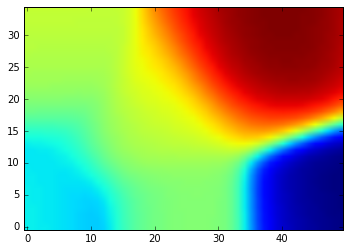

In [13]:
plt.imshow(wfirst_som.codebook[:,:,0],origin='lower')

(-1.0, 2)

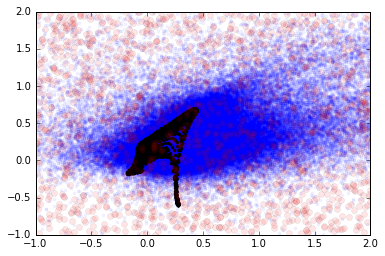

In [14]:
ugsom=wfirst_som.codebook[:,:,1].reshape(wfirst_som.num_cells)
grsom=wfirst_som.codebook[:,:,0].reshape(wfirst_som.num_cells)
ck=np.random.uniform(low=-1.0,high=2.0,size=[wfirst_som.xsize,wfirst_som.ysize,wfirst_som.features]) 

plt.plot(data[:,0],data[:,1],'b.',alpha=0.05)
plt.plot(ugsom,grsom,'k.')
plt.plot(ck[:,:,0],ck[:,:,1],'ro',alpha=0.1)
plt.xlim([-1.,2])
plt.ylim([-1.,2])
